In [1]:
import torch

In [2]:
X = torch.load('x_trim_5.pt')
Y = torch.load('y_trim_5.pt')

C:\Users\timec\AppData\Local\Temp\ipykernel_25208\2518651434.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load('x_trim_5.pt')
C:\Users\timec\AppData\Local\T

In [3]:
X.size(), Y.size()

(torch.Size([1362676, 150]), torch.Size([1362676]))

In [4]:
# Parameters
input_size = X.size(1)


In [5]:
from torch.utils.data import random_split, DataLoader

# Example data
X_train = X  
y_train = Y  

# Define the size for the training and testing splits
train_size = int(0.8 * len(X_train))  # 80% for training
test_size = len(X_train) - train_size  # remaining 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(list(zip(X_train, y_train)), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
from torch.utils.data import random_split, DataLoader

# Example data
X_train = X
y_train = Y

# Define the sizes for training, validation, and testing splits
train_size = int(0.7 * len(X_train))  # 70% for training
val_size = int(0.15 * len(X_train))  # 15% for validation
test_size = len(X_train) - train_size - val_size  # remaining 15% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    list(zip(X_train, y_train)), [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Hyperparameters


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network for multi-class classification
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)          # Second fully connected layer
        self.fc3 = nn.Linear(64, num_classes)  # Output layer (2 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation after the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation after the second layer
        x = self.fc3(x)              # Output layer (no activation needed for multi-class classification)
        return x
# Initialize the neural network
model = SimpleNN(input_size=input_size, num_classes=2)  # 150 input features, 2 classes

# Loss function (CrossEntropyLoss is used for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class EnhancedNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, vocab_size):
        super(EnhancedNN, self).__init__()

        # Embedding Layer (if input is categorical)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # First hidden layer (after embedding)
        self.fc1 = nn.Linear(input_dim * embedding_dim, hidden_dim)  # input_dim * embedding_dim because of the embedding layer
        self.relu1 = nn.ReLU()

        # Second hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()

        # Output layer
        self.fc3 = nn.Linear(hidden_dim, 1) # Single output for binary classification
        
    def forward(self, x):
        # Apply embedding layer (assuming x contains integer indices for categories)
        x = self.embedding(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # Flatten the output from the embedding layer to feed into fully connected layers
        x = x.view(x.size(0), -1)  # Flattening the tensor
        
        # First hidden layer
        x = self.relu1(self.fc1(x))
        
        # Second hidden layer
        x = self.relu2(self.fc2(x))

        # Output layer (no activation function, raw logits for multi-class classification)
        x = self.fc3(x)
        return x

# Hyperparameters
vocab_size = 5460      # Size of vocabulary for the embedding layer
embedding_dim = 128     # Dimension of embedding vectors
hidden_dim = 512        # Number of units in hidden layers
num_classes = 2         # Number of classes (not used due to binary classification)
input_dim = 150         # The length of your input (assuming each input is of length 150)

# Create the model
model = EnhancedNN(input_dim, embedding_dim, hidden_dim, vocab_size)

# Print the model architecture
print(model)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


EnhancedNN(
  (embedding): Embedding(5460, 128)
  (fc1): Linear(in_features=19200, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)


In [10]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
# Move the model to the GPU
model.to(device)

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device).long(), labels.to(device).float() # Ensure labels are float for BCEWithLogitsLoss

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        predicted = torch.sigmoid(outputs) > 0.5
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device).long(), labels.to(device).float()

        outputs = model(inputs).squeeze(1)
        predicted = torch.sigmoid(outputs) > 0.5
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Using cuda
Epoch 1/10, Loss: 0.3259, Accuracy: 85.58%
Epoch 2/10, Loss: 0.2406, Accuracy: 91.63%
Epoch 3/10, Loss: 0.2298, Accuracy: 92.05%
Epoch 4/10, Loss: 0.2230, Accuracy: 92.36%
Epoch 5/10, Loss: 0.2171, Accuracy: 92.56%
Epoch 6/10, Loss: 0.2150, Accuracy: 92.65%
Epoch 7/10, Loss: 0.2112, Accuracy: 92.80%
Epoch 8/10, Loss: 0.2096, Accuracy: 92.84%
Epoch 9/10, Loss: 0.2060, Accuracy: 93.00%
Epoch 10/10, Loss: 0.2030, Accuracy: 93.11%
Test Accuracy: 92.31%


In [11]:
torch.save(model.state_dict(), "model_enhanced_v1.pth")

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
# Move the model to the GPU
model.to(device)

# Number of epochs
num_epochs = 10

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

best_val_loss = float('inf')  # Initialize with infinity
checkpoint_path = "best_model.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).long(), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Collect predictions for accuracy
        preds = torch.sigmoid(outputs) > 0.5
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).long(), labels.to(device).float()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    # Save the model if validation loss is lower
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Epoch {epoch+1}: New best model saved with validation loss {avg_val_loss:.4f}")


    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f},"
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")


Using cuda
Epoch 1: New best model saved with validation loss 0.2294
Epoch 1/10, Train Loss: 0.1955, Train Accuracy: 0.9344, Train F1: 0.9330,Val Loss: 0.2294, Val Accuracy: 0.9206, Val F1: 0.9184
Epoch 2/10, Train Loss: 0.1926, Train Accuracy: 0.9354, Train F1: 0.9342,Val Loss: 0.2393, Val Accuracy: 0.9199, Val F1: 0.9196
Epoch 3/10, Train Loss: 0.1904, Train Accuracy: 0.9368, Train F1: 0.9356,Val Loss: 0.2303, Val Accuracy: 0.9221, Val F1: 0.9203
Epoch 4/10, Train Loss: 0.1875, Train Accuracy: 0.9384, Train F1: 0.9372,Val Loss: 0.2428, Val Accuracy: 0.9208, Val F1: 0.9193
Epoch 5/10, Train Loss: 0.1840, Train Accuracy: 0.9408, Train F1: 0.9395,Val Loss: 0.2357, Val Accuracy: 0.9227, Val F1: 0.9215
Epoch 6/10, Train Loss: 0.1797, Train Accuracy: 0.9430, Train F1: 0.9418,Val Loss: 0.2428, Val Accuracy: 0.9199, Val F1: 0.9173
Epoch 7/10, Train Loss: 0.1748, Train Accuracy: 0.9453, Train F1: 0.9441,Val Loss: 0.2466, Val Accuracy: 0.9228, Val F1: 0.9218
Epoch 8/10, Train Loss: 0.1721, Tra

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device).long(), labels.to(device).float()

        outputs = model(inputs).squeeze(1)
        predicted = torch.sigmoid(outputs) > 0.5
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 91.62%


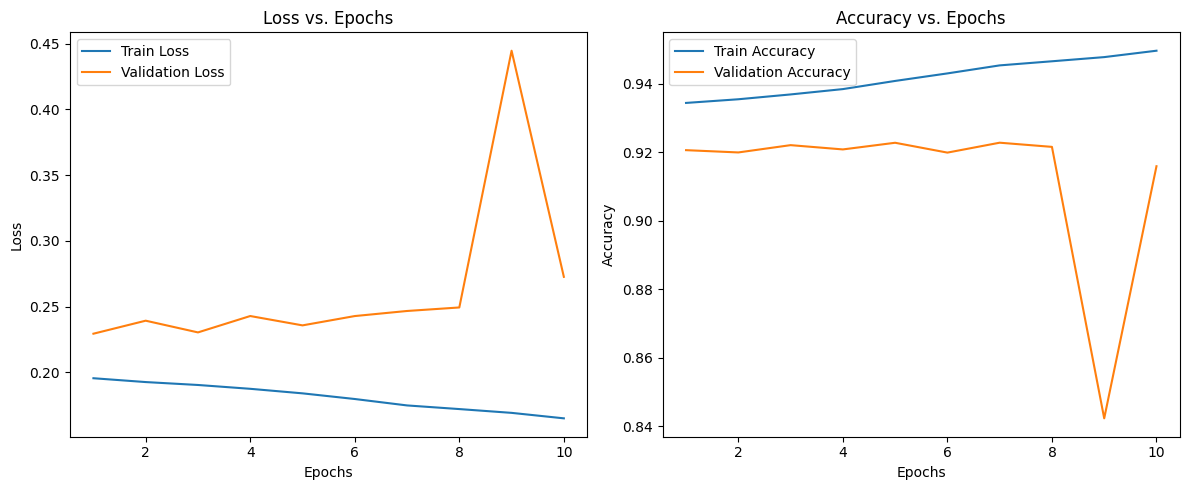

In [18]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()
